## 🎓 Sistema de Recomendação de Cursos da Udemy com BM25 e RankT5

Este projeto propõe um sistema híbrido de recomendação de cursos online, combinando técnicas de recuperação de informação com aprendizado supervisionado. A abordagem utiliza:

- 🔍 BM25 para recuperação inicial baseada em similaridade textual
- 🧠 RankT5 (modelo baseado em T5) para reranqueamento supervisionado com entendimento semântico

O objetivo é recomendar cursos mais relevantes com base apenas no título da consulta, simulando um cenário com informações limitadas, como em buscas rápidas feitas por usuários em plataformas educacionais como a Udemy.


### 1. 🛠️ Configuração do NLTK, Stop Words, remoção de caractreres especiais e lematização

Nesta etapa inicial, realizamos a preparação do ambiente de processamento de linguagem natural com a biblioteca NLTK. 

Foram baixados os recursos essenciais:
- Tokenizador `punkt` (para dividir textos em palavras)
- Lista de `stopwords` (palavras comuns que não carregam muito significado)

Além das stopwords padrão da língua inglesa, foram adicionadas **stopwords específicas do domínio de cursos de tecnologia**, como "course", "tutorial", "beginner", "bootcamp", entre outras. Isso garante que o modelo se concentre em termos realmente informativos, como linguagens de programação, tecnologias e temas de conteúdo.

Essa filtragem é aplicada durante a tokenização dos títulos dos cursos, melhorando a qualidade da entrada para o cálculo de similaridade com BM25.

In [7]:
import os
import contextlib
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# --- Configura NLTK ---
nltk_data_dir = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.data.path = [nltk_data_dir]

with open(os.devnull, 'w') as fnull:
    with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
        nltk.download("punkt", download_dir=nltk_data_dir)
        nltk.download("stopwords", download_dir=nltk_data_dir)
        nltk.download("wordnet", download_dir=nltk_data_dir)
        nltk.download("omw-1.4", download_dir=nltk_data_dir)  

# --- Cria conjunto de stopwords ---
stop_words = set(stopwords.words('english'))

extra_stops = {
    "learn", "learning", "course", "courses", "tutorial", "introduction", "intro",
    "guide", "complete", "bootcamp", "beginner", "beginners", "masterclass", "hands-on",
    "project", "projects", "practical", "training", "zero", "hero", "step", "steps",
    "certification", "exam", "pass", "skills", "foundation", "foundations", "build",
    "create", "develop", "start", "basic", "advance", "advanced", "series", "crash",
    "overview", "from", "scratch", "professional", "essentials"
}

custom_stopwords = stop_words.union(extra_stops)

# def tokenize_course_title(text):
#     text_clean = re.sub(r"[^a-zA-Z0-9\s]", "", text.lower())
#     tokens = word_tokenize(text_clean)
#     return [word for word in tokens if word.isalnum() and word not in custom_stopwords]

# --- Instancia o lematizador ---
lemmatizer = WordNetLemmatizer()

# --- Função de Tokenização + Lematização + Limpeza ---
def tokenize_course_title(text):
    # Remove caracteres especiais
    text_clean = re.sub(r"[^a-zA-Z0-9\s]", "", text.lower())
    tokens = word_tokenize(text_clean)

    # Lematizar tokens
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
    ]


    return tokens


[nltk_data] Downloading package punkt to /Users/luattarian/Documents/G
[nltk_data]     itHub/projeto_aplicado_III/notebooks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/luattarian/Documen
[nltk_data]     ts/GitHub/projeto_aplicado_III/notebooks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/luattarian/Documents
[nltk_data]     /GitHub/projeto_aplicado_III/notebooks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/luattarian/Documents
[nltk_data]     /GitHub/projeto_aplicado_III/notebooks/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 2. 📥 Importação dos Dados

Nesta etapa, importamos os dados brutos que servirão como base para o sistema de recomendação. Os dados consistem em um arquivo CSV contendo aproximadamente 22 mil títulos de cursos da categoria "IT & Software" da plataforma Udemy, extraído da base pública do Kaggle.

Apenas o campo de título é utilizado, o que simula um cenário desafiador, onde o sistema precisa fazer recomendações sem contar com descrições detalhadas, avaliações de usuários ou outras informações adicionais.

Esses títulos serão utilizados para:
- Construir o índice BM25 para recuperação inicial
- Gerar pares positivos e negativos para o treinamento supervisionado do RankT5


In [8]:
import pandas as pd

print("📂 Carregando cursos da base Udemy...")
df = pd.read_csv("../data/udemy_output_All_IT__Software_p1_p626.csv")
titles = df["title"].dropna().drop_duplicates().tolist()

📂 Carregando cursos da base Udemy...


### 3. 🔗 Geração de Dados para Treinamento do RankT5

Nesta etapa, construímos a base supervisionada necessária para treinar o modelo RankT5. Para isso, utilizamos o algoritmo BM25 para medir a similaridade entre os títulos dos cursos da base da Udemy.

Para cada curso (considerado como consulta), são selecionados:
- **5 pares positivos**: cursos mais semelhantes com base na pontuação do BM25.
- **5 pares negativos**: cursos com baixa similaridade (por exemplo, a partir do 50º resultado).

Cada par é então formatado como uma entrada textual no seguinte padrão:

E recebe um rótulo:
- `"1"` se o par for considerado relevante (positivo)
- `"0"` se o par for irrelevante (negativo)

Esses exemplos textuais são utilizados como entrada para o treinamento supervisionado do modelo RankT5, permitindo que ele aprenda a identificar a relevância entre consultas e cursos com base no texto.



In [ ]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
from rank_bm25 import BM25Okapi

# Tokenizar os títulos
tokenized_titles = [tokenize_course_title(t) for t in titles]
bm25 = BM25Okapi(tokenized_titles)

print("Calculando matriz de similaridade BM25...")
bm25_matrix = np.array([bm25.get_scores(tokens) for tokens in tqdm(tokenized_titles)])

print("Gerando pares com base nas similaridades BM25...")
pairs = []
num_pairs = 5
for i in tqdm(range(len(titles))):
    scores = bm25_matrix[i]
    sorted_indices = scores.argsort()[::-1]
    sorted_indices = sorted_indices[sorted_indices != i]  # remove o próprio
    
    # Pares positivos (títulos similares) tres mais similares
    positives = sorted_indices[:num_pairs]
    # Pares negativos (títulos não similares) tres aleatórios com posições acima de 50 
    negatives = random.sample(list(sorted_indices[50:]), num_pairs) if len(sorted_indices) > 50 else sorted_indices[-1*num_pairs:]

    for j in positives:
        pairs.append((titles[i], titles[j], 1))
    for j in negatives:
        pairs.append((titles[i], titles[j], 0))

# Salvar os pares no formato eperado pelo RankT5
df_pairs = pd.DataFrame(pairs, columns=["query", "course", "label"])
df_pairs.to_csv("../data/bm25_pairs-new.csv", index=False)

print("Pares salvos em 'bm25_pairs.csv'")

Calculando matriz de similaridade BM25...


100%|██████████| 22750/22750 [03:06<00:00, 121.92it/s]


Gerando pares com base nas similaridades BM25...


 34%|███▍      | 7769/22750 [00:06<00:11, 1288.55it/s]

### 4. 📊 Divisão dos Dados em Treino, Teste e Validação

Antes de treinar o modelo RankT5, é necessário dividir os pares gerados em dois subconjuntos:

- **Conjunto de treinamento (train):** utilizado para ajustar os pesos do modelo supervisionado.
- **Conjunto de teste (test):** utilizado para avaliar a capacidade do modelo em generalizar para exemplos que ele nunca viu.
- **Conjunto de validação (val):** utilizado para ajustar hiperparâmetros e evitar overfitting.




In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Carrega os pares
df = pd.read_csv("../data/bm25_pairs-new.csv")

# Formata para RankT5
df_rankt5 = pd.DataFrame({
    "input_text": df.apply(lambda row: f"Query: {row['query']} Course: {row['course']}", axis=1),
    "label": df["label"].astype(str)
})

# Primeiro, separa treino (70%) e temp (30%)
train_df, temp_df = train_test_split(
    df_rankt5, 
    test_size=0.3, 
    random_state=42,
    stratify=df_rankt5["label"]
)

# Depois, separa temp em validação (15%) e teste (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # metade para validação, metade para teste
    random_state=42,
    stratify=temp_df["label"]
)

# Salva os conjuntos em CSV
train_df.to_csv("../data/rankt5_train.csv", index=False)
val_df.to_csv("../data/rankt5_val.csv", index=False)
test_df.to_csv("../data/rankt5_test.csv", index=False)

### 5. 🧠 Treinamento do Modelo RankT5

Com os dados supervisionados prontos (pares no formato "Query: ... Course: ..." com rótulo 1 ou 0), iniciamos o treinamento do modelo RankT5.

Utilizamos o modelo `t5-small` da biblioteca Hugging Face Transformers como base. Ele é um modelo encoder-decoder, originalmente treinado com a abordagem "texto para texto", o que o torna ideal para tarefas como classificação, tradução, sumarização e, neste caso, reranqueamento supervisionado.

Durante o processo de treinamento, várias melhorias foram implementadas para maximizar o desempenho:

- 📚 **Pré-processamento aprimorado**: além da tokenização, aplicamos limpeza de caracteres especiais, normalização para minúsculas, remoção de stopwords customizadas e lematização para reduzir variações morfológicas.
- 🔀 **Divisão estruturada dos dados**:
  - 70% para **treinamento** (`train`),
  - 15% para **validação** (`val`),
  - 15% para **teste** (`test`).
  Essa divisão assegura melhor ajuste do modelo e avaliação imparcial.
- 🔍 **Busca de hiperparâmetros**: utilizamos `hyperparameter_search` com o backend `ray`, testando diferentes valores de learning rate, batch size, número de épocas, weight decay e warmup steps para encontrar a melhor configuração automaticamente.
- 🚀 **Treinamento final**: após encontrar a melhor combinação de hiperparâmetros, o modelo foi treinado novamente do zero utilizando os dados de treino e validação.

Durante o treinamento:
- 📥 O modelo recebe pares de entrada tokenizados e aprende a prever se o curso é ou não relevante para a consulta.
- 📈 A performance é monitorada por meio da `validation_loss`, que indica a capacidade do modelo em generalizar para dados não vistos.
- 🏆 O melhor modelo baseado na menor perda de validação é salvo automaticamente.

Esse processo transformou o T5 em um modelo capaz de entender relações semânticas entre consultas e títulos de cursos, superando a simples similaridade lexical inicial.


In [ ]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
from ray import tune 
import json

# 1. Carregar e preparar os dados
df_train = pd.read_csv("../data/rankt5_train.csv")
df_val = pd.read_csv("../data/rankt5_val.csv")
df_test = pd.read_csv("../data/rankt5_test.csv")

# Dataset Hugging Face
def preprocess(line):
    input_text = str(line["input_text"])
    label_text = str(line["label"])

    input_enc = tokenizer(
        input_text,
        padding="max_length",
        truncation=True,
        max_length=64
    )
    label_enc = tokenizer(
        label_text,
        padding="max_length",
        truncation=True,
        max_length=4
    )

    input_enc["labels"] = label_enc["input_ids"]
    return input_enc

tokenizer = T5Tokenizer.from_pretrained("t5-small")
def model_init():
    return T5ForConditionalGeneration.from_pretrained("t5-small")

train_dataset = Dataset.from_pandas(df_train).map(preprocess, remove_columns=df_train.columns.tolist())
val_dataset = Dataset.from_pandas(df_val).map(preprocess, remove_columns=df_val.columns.tolist())
test_dataset = Dataset.from_pandas(df_test).map(preprocess, remove_columns=df_test.columns.tolist())

# 2. Definir argumentos de treino iniciais
training_args = TrainingArguments(
    output_dir="../data/rankt5_output_search",
    eval_strategy="epoch",  
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=10,
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"  # Desativa WandB ou Huggingface Hub
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 3. Definir espaço de busca para hiperparâmetros
def model_hp_space(trial):
    return {
        "learning_rate": tune.loguniform(1e-5, 5e-4),
        "weight_decay": tune.uniform(0.0, 0.3),
        "num_train_epochs": tune.choice([2, 3, 4, 5]),
        "per_device_train_batch_size": tune.choice([8, 16]),
        "warmup_steps": tune.choice([0, 100, 300, 500])
    }

# 4. Executar busca de hiperparâmetros
print("🔍 Iniciando busca de hiperparâmetros...")
best_run = trainer.hyperparameter_search(
    direction="minimize",   
    backend="ray",         
    n_trials=5,            
    hp_space=model_hp_space,
    resources_per_trial={"cpu": 5, "gpu": 0}
)

print("🏆 Melhor configuração encontrada:")
print(best_run)

with open("../data/best_hyperparameters.json", "w") as f:
    json.dump(best_run.hyperparameters, f, indent=4)

print("✅ Hiperparâmetros salvos em best_hyperparameters.json")



In [ ]:
 # 5. Atualizar argumentos de treino com melhores hiperparâmetros
training_args_final = TrainingArguments(
    output_dir="../data/rankt5_output_final",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_run.hyperparameters["learning_rate"],
    weight_decay=best_run.hyperparameters["weight_decay"],
    per_device_train_batch_size=best_run.hyperparameters["per_device_train_batch_size"],
    per_device_eval_batch_size=best_run.hyperparameters["per_device_train_batch_size"],
    num_train_epochs=best_run.hyperparameters["num_train_epochs"],
    warmup_steps=best_run.hyperparameters["warmup_steps"],
    logging_dir="./logs_final",
    logging_steps=10,
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

# 6. Treinador final
model_final = T5ForConditionalGeneration.from_pretrained("t5-small")
trainer_final = Trainer(
    model=model_final,
    args=training_args_final,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# 7. Treinar modelo final
print("🚀 Treinando modelo final com melhores hiperparâmetros...")
trainer_final.train()

# 8. Avaliar no conjunto de teste
print("🧪 Avaliando desempenho no conjunto de teste...")
metrics = trainer_final.evaluate(test_dataset)
print("📈 Métricas no conjunto de teste:", metrics)

### 6. 🤝 Função de Recomendação Híbrida com BM25 e RankT5

Esta etapa implementa a lógica final do sistema de recomendação, combinando a recuperação inicial com BM25 e o reranqueamento supervisionado com RankT5.

A função híbrida opera em dois estágios:

1. **🔍 Recuperação com BM25 (não supervisionado)**  
   Dada uma consulta (por exemplo, "learn python for data science"), o BM25 busca no corpus os cursos com títulos mais similares, com base na frequência e distribuição dos termos. Os **top-50 cursos mais similares** são selecionados como candidatos iniciais.

2. **🧠 Reranqueamento com RankT5 (supervisionado)**  
   Cada par (consulta + título do curso candidato) é formatado como:  
   Esses pares são passados para o modelo RankT5, que retorna uma pontuação de relevância para cada curso. Os cursos são então **reordenados de acordo com essas pontuações**, priorizando aqueles que o modelo considera semanticamente mais relevantes.

🔁 O resultado final é uma lista de recomendações ordenadas, que combina a eficiência do BM25 com a capacidade semântica do RankT5, entregando sugestões mais precisas e contextualizadas mesmo sem dados de interação do usuário.

 

In [9]:
import torch
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
from transformers import T5Tokenizer, T5ForConditionalGeneration

# === Carregar modelo RankT5 já treinado ===
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("../data/rankt5_output_final/checkpoint-79628") 

tokenized_titles = [tokenize_course_title(t) for t in titles]
bm25 = BM25Okapi(tokenized_titles)

# === Função principal de recomendação híbrida ===
def recommend_courses(query, top_k=5):
    query_tokens = tokenize_course_title(query)
    scores = bm25.get_scores(query_tokens)

    # Top-50 mais relevantes por BM25
    top_50_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:50]
    top_50_courses = [(titles[i], scores[i]) for i in top_50_indices]

    # Criar pares para RankT5
    input_pairs = [f"Query: {query} Course: {course}" for course, _ in top_50_courses]

    # Inferência com RankT5
    rankt5_scores = []
    for text, (title, bm25_score) in zip(input_pairs, top_50_courses):
        inputs = tokenizer(text, return_tensors="pt", truncation=True)
        with torch.no_grad():
            output = model.generate(**inputs)
        prediction = tokenizer.decode(output[0], skip_special_tokens=True)
        score = int(prediction) if prediction.isdigit() else 0
        rankt5_scores.append((title, score, bm25_score))

    # Ordenar pelo score do RankT5 e retornar Top-K
    ranked = sorted(rankt5_scores, key=lambda x: (-x[1], -x[2]))  # primeiro pelo T5, depois BM25
    return ranked[:top_k]

def recommend_and_print(query, top_k=5):
    recommendations = recommend_courses(query, top_k)
    print(f"\n🎯 Recomendação para: '{query}'\n")
    for i, (title, score, bm25_score) in enumerate(recommendations, 1):
        print(f"{i}. {title} (RankT5: {score}, BM25: {bm25_score:.2f})")



### 7. 🧪 Teste da Função de Recomendação Híbrida

Nesta etapa, testamos o sistema de recomendação completo, combinando a recuperação com BM25 e o reranqueamento com RankT5.

In [10]:
recommend_and_print("Python for beginners")
recommend_and_print("Java programming")
recommend_and_print("Machine learning with Python")
recommend_and_print("Web development with JavaScript")
recommend_and_print("Data science and analytics")
recommend_and_print("Cybersecurity")



🎯 Recomendação para: 'Python for beginners'

1. Python for Beginners (RankT5: 1, BM25: 11.76)
2. Python for beginners (RankT5: 1, BM25: 11.76)
3. Python Complete Course For Python Beginners (RankT5: 1, BM25: 11.01)
4. Python for Beginners: Learn Python Hands-on (Python 3) (RankT5: 1, BM25: 10.85)
5. Python for Absolute beginner (Python 3 - python programming) (RankT5: 1, BM25: 10.85)

🎯 Recomendação para: 'Java programming'

1. Java Network Programming - TCP/IP Socket Programming (RankT5: 1, BM25: 11.26)
2. Java MTA - Introduction to Programming Using Java 98-388 (RankT5: 1, BM25: 10.26)
3. Java Programming In-depth Questions Answered By Java Expert (RankT5: 1, BM25: 10.26)
4. Java to Develop Programming Skills (RankT5: 1, BM25: 10.14)
5. Programming Network Applications in Java (RankT5: 1, BM25: 10.14)

🎯 Recomendação para: 'Machine learning with Python'

1. Python Programming with Machine Learning & Deep Learning (RankT5: 1, BM25: 17.88)
2. Introduction To Machine Learning with Pyth

### 8. 📊 Avaliação Comparativa entre BM25 e RankT5
Nesta etapa, realizamos uma avaliação comparativa entre o BM25 e o RankT5, utilizando o nDCG@5, MAP e MRR como métrica de qualidade.

Processando consultas: 100%|██████████| 18277/18277 [02:19<00:00, 131.49it/s]



=== Resultados ===
nDCG@5   - BM25   : 0.2819
nDCG@5   - RankT5 : 0.9934
MAP      - BM25   : 0.2330
MAP      - RankT5 : 0.9923
MRR      - BM25   : 0.2314
MRR      - RankT5 : 0.9942


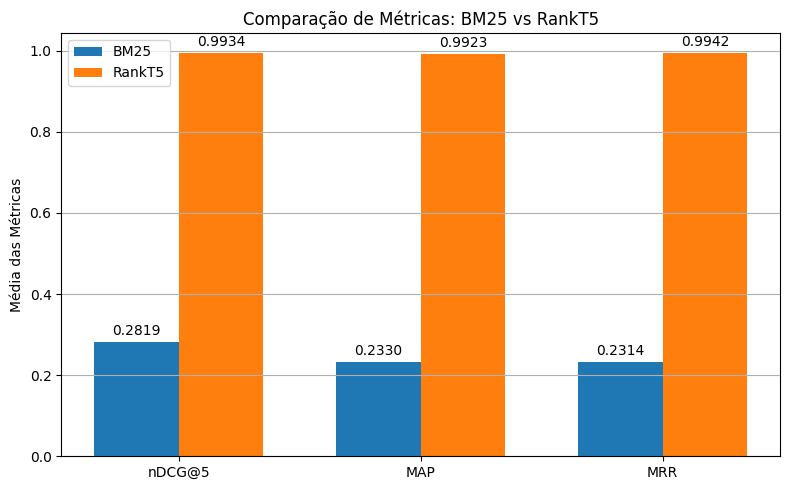

In [11]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration
from rank_bm25 import BM25Okapi
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def tokenize_course_title(text):
    text_clean = re.sub(r"[^a-zA-Z0-9\s]", "", text.lower())
    return word_tokenize(text_clean)

def predict_rankt5_batch(texts, tokenizer, model, device, batch_size=32):
    scores = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Inferência RankT5"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=64)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model.generate(inputs["input_ids"], max_length=4)
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        batch_scores = [1.0 if d.strip() == "1" else 0.0 for d in decoded]
        scores.extend(batch_scores)
    return scores

def average_precision(y_true, y_score):
    sorted_indices = np.argsort(y_score)[::-1]
    y_true_sorted = np.take(y_true, sorted_indices)
    precisions = []
    num_hits = 0
    for i, rel in enumerate(y_true_sorted):
        if rel > 0:
            num_hits += 1
            precisions.append(num_hits / (i + 1))
    return np.mean(precisions) if precisions else 0.0

def reciprocal_rank(y_true, y_score):
    sorted_indices = np.argsort(y_score)[::-1]
    y_true_sorted = np.take(y_true, sorted_indices)
    for i, rel in enumerate(y_true_sorted):
        if rel > 0:
            return 1.0 / (i + 1)
    return 0.0

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("../data/rankt5_output_final/checkpoint-39814").to(device)
model.eval()

df = pd.read_csv("../data/rankt5_test.csv")
df["query"] = df["input_text"].str.extract(r"Query: (.*?) Course:")
df["course"] = df["input_text"].str.extract(r"Course: (.*)")
df["label"] = df["label"].fillna(0)

titles = df["course"].unique().tolist()
tokenized_titles = [tokenize_course_title(t) for t in tqdm(titles, desc="Tokenizando cursos")]
bm25 = BM25Okapi(tokenized_titles)

df["rankt5_score"] = predict_rankt5_batch(df["input_text"].tolist(), tokenizer, model, device)

query_labels = df.groupby("query", group_keys=False).apply(
    lambda g: dict(zip(g["course"], g["label"])),
    include_groups=False
).to_dict()

query_scores = df.groupby("query", group_keys=False).apply(
    lambda g: dict(zip(g["course"], g["rankt5_score"])),
    include_groups=False
).to_dict()

ndcg5_bm25, ndcg5_rankt5 = [], []
map_bm25, map_rankt5 = [], []
mrr_bm25, mrr_rankt5 = [], []

for query in tqdm(query_labels, desc="Processando consultas"):
    relevant_courses = query_labels[query]
    if sum(relevant_courses.values()) == 0 or len(relevant_courses) < 2:
        continue

    query_tokens = tokenize_course_title(query)
    bm25_scores = bm25.get_scores(query_tokens)
    top_indices = np.argsort(bm25_scores)[::-1][:len(relevant_courses)]
    top_courses = [titles[i] for i in top_indices]

    y_true_bm25 = [relevant_courses.get(c, 0) for c in top_courses]
    y_score_bm25 = [bm25_scores[i] for i in top_indices]

    y_true_rankt5 = [relevant_courses.get(c, 0) for c in titles]
    y_score_rankt5 = [query_scores[query].get(c, 0) for c in titles]

    ndcg5_bm25.append(ndcg_score([y_true_bm25], [y_score_bm25], k=5))
    ndcg5_rankt5.append(ndcg_score([y_true_rankt5], [y_score_rankt5], k=5))

    map_bm25.append(average_precision(y_true_bm25, y_score_bm25))
    map_rankt5.append(average_precision(y_true_rankt5, y_score_rankt5))

    mrr_bm25.append(reciprocal_rank(y_true_bm25, y_score_bm25))
    mrr_rankt5.append(reciprocal_rank(y_true_rankt5, y_score_rankt5))

# --- Resultados médios ---
avg_ndcg5_bm25 = np.mean(ndcg5_bm25)
avg_ndcg5_rankt5 = np.mean(ndcg5_rankt5)
avg_map_bm25 = np.mean(map_bm25)
avg_map_rankt5 = np.mean(map_rankt5)
avg_mrr_bm25 = np.mean(mrr_bm25)
avg_mrr_rankt5 = np.mean(mrr_rankt5)

print("\n=== Resultados ===")
print(f"nDCG@5   - BM25   : {avg_ndcg5_bm25:.4f}")
print(f"nDCG@5   - RankT5 : {avg_ndcg5_rankt5:.4f}")
print(f"MAP      - BM25   : {avg_map_bm25:.4f}")
print(f"MAP      - RankT5 : {avg_map_rankt5:.4f}")
print(f"MRR      - BM25   : {avg_mrr_bm25:.4f}")
print(f"MRR      - RankT5 : {avg_mrr_rankt5:.4f}")

# --- Gráfico de barras agrupado ---
labels = ['nDCG@5', 'MAP', 'MRR']
bm25_scores = [avg_ndcg5_bm25, avg_map_bm25, avg_mrr_bm25]
rankt5_scores = [avg_ndcg5_rankt5, avg_map_rankt5, avg_mrr_rankt5]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, bm25_scores, width, label='BM25')
bars2 = ax.bar(x + width/2, rankt5_scores, width, label='RankT5')

ax.set_ylabel('Média das Métricas')
ax.set_title('Comparação de Métricas: BM25 vs RankT5')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y')

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

